In [1]:
import torch 
import numpy as np 
import matplotlib.pyplot as plt 
import pandas as pd 
from tqdm.notebook import tqdm 

# Exploring Dataset 

In [2]:
data = pd.read_csv("mnist_dataset.csv")
data.head()

,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [3]:
image = data.iloc[7] # selecting image at index 7 
image = np.array(image).astype('float32')
image = np.reshape(image,(28,28)) # reshaping image to 28 x 28 
image = image / 255 # to scale image between 0 to 1

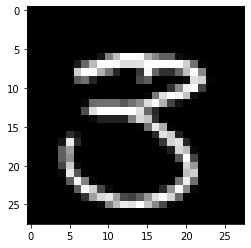

In [4]:
plt.imshow(image,cmap = "gray") 

In [5]:
noisy_image = image + 0.2 * np.random.randn(*image.shape) # Adding random noise to image 
noisy_image = np.clip(noisy_image,0,1) #ranging between 0 - 1

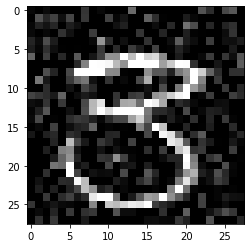

In [6]:
plt.imshow(noisy_image,cmap = "gray")

# Data Preparation 

In [7]:
from torch.utils.data import Dataset
from helper import show_image, ToTensorForAE

In [8]:
class MNIST_AE_Dataset(Dataset):
    
    def __init__(self,csv_file,noise_factor = 0.2,transform = None):
        
        self.data = pd.read_csv(csv_file)
        self.transform = transform 
        self.noise_factor = noise_factor
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self,idx):
        
        img = self.data.iloc[idx]
        img = np.array(img)
        img = np.reshape(img,(28,28,1)) / 255
        
        noisy_img = img + self.noise_factor * np.random.randn(*img.shape)
        noisy_img = np.clip(noisy_img,0.,1.)
        
        sample = (noisy_img,img)
        
        if self.transform:
            sample = self.transform(sample)
            
        return sample

In [9]:
trainset = MNIST_AE_Dataset('mnist_dataset.csv',transform = ToTensorForAE())
# ToTensorAE is a user defined function that converts numpy array image to Torch tensor and shifts the channel axis to the 0th axis.
# (height , width , channel) --> (channel , height , width)
# This is the convention for PyTorch model's inputs

In [10]:
print("Size of trainset : {}".format(len(trainset)))

Size of trainset : 42000


In [11]:
noisy_image,org_image = trainset[6]
noisy_image.shape

torch.Size([1, 28, 28])

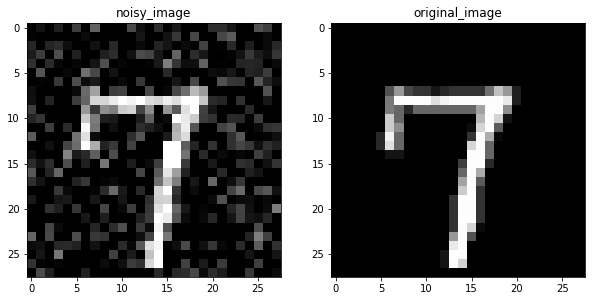

In [12]:
show_image(noisy_image,org_image) 

# Load dataset into batches

In [13]:
from torch.utils.data import DataLoader 

In [14]:
trainloader = DataLoader(trainset,batch_size = 16,shuffle = True)

In [15]:
dataiter = iter(trainloader)
noisy_image, org_image = dataiter.next()

print("Shape of loading one batch : {}".format(noisy_image.shape))
print("Shape of loading one batch : {}".format(org_image.shape))

print("Total no. of batches present in trainloader : {}".format(len(trainloader))) #total no. of batches
print("Total no. of examples present in trainloader : {}".format(len(trainloader.dataset)))

Shape of loading one batch : torch.Size([16, 1, 28, 28])
Shape of loading one batch : torch.Size([16, 1, 28, 28])
Total no. of batches present in trainloader : 2625
Total no. of examples present in trainloader : 42000


# Create AutoEncoder Model

In [16]:
import torch
from torch import nn 
from torchsummary import summary

In [17]:
def Encoder():
    
    enc = nn.Sequential(
        
        nn.Conv2d(in_channels = 1, out_channels = 16,kernel_size = (3,3),padding = 1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size = (2,2)), 
        nn.Conv2d(in_channels = 16, out_channels = 32,kernel_size = (3,3),padding = 1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size = (2,2))
    )
    
    return enc

In [18]:
def Decoder():
    
    dec = nn.Sequential(
        
        nn.ConvTranspose2d(in_channels = 32,out_channels = 16,kernel_size = (2,2),stride = 2),
        nn.ReLU(),
        nn.ConvTranspose2d(in_channels = 16,out_channels = 1,kernel_size = (2,2),stride = 2),
        nn.Sigmoid()
    )
    
    return dec

In [19]:
class ConvAutoencoder(nn.Module):
    def __init__(self):
        super(ConvAutoencoder, self).__init__()
       
        
        self.encoder = Encoder()
        self.decoder = Decoder()


    def forward(self, x):
       
        x = self.encoder(x)
        x = self.decoder(x)
        return x

model = ConvAutoencoder()
model

ConvAutoencoder(
  (encoder): Sequential(
    (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  )
  (decoder): Sequential(
    (0): ConvTranspose2d(32, 16, kernel_size=(2, 2), stride=(2, 2))
    (1): ReLU()
    (2): ConvTranspose2d(16, 1, kernel_size=(2, 2), stride=(2, 2))
    (3): Sigmoid()
  )
)

In [20]:
summary(model,input_size = (1,28,28))

Layer (type:depth-idx)                   Param #
├─Sequential: 1-1                        --
|    └─Conv2d: 2-1                       160
|    └─ReLU: 2-2                         --
|    └─MaxPool2d: 2-3                    --
|    └─Conv2d: 2-4                       4,640
|    └─ReLU: 2-5                         --
|    └─MaxPool2d: 2-6                    --
├─Sequential: 1-2                        --
|    └─ConvTranspose2d: 2-7              2,064
|    └─ReLU: 2-8                         --
|    └─ConvTranspose2d: 2-9              65
|    └─Sigmoid: 2-10                     --
Total params: 6,929
Trainable params: 6,929
Non-trainable params: 0


Layer (type:depth-idx)                   Param #
├─Sequential: 1-1                        --
|    └─Conv2d: 2-1                       160
|    └─ReLU: 2-2                         --
|    └─MaxPool2d: 2-3                    --
|    └─Conv2d: 2-4                       4,640
|    └─ReLU: 2-5                         --
|    └─MaxPool2d: 2-6                    --
├─Sequential: 1-2                        --
|    └─ConvTranspose2d: 2-7              2,064
|    └─ReLU: 2-8                         --
|    └─ConvTranspose2d: 2-9              65
|    └─Sigmoid: 2-10                     --
Total params: 6,929
Trainable params: 6,929
Non-trainable params: 0

# Train AutoEncoder Model 

In [21]:
from torch import optim
from tqdm import tqdm 

In [22]:
optimizer = optim.Adam(model.parameters(),lr = 0.001)
criterion = nn.MSELoss()
epochs = 5

In [23]:
for i in range(epochs):
    
    train_loss = 0.0
    
    for noisy_image,image in tqdm(trainloader):
        
        optimizer.zero_grad()
        pred_image = model(noisy_image)
        loss = criterion(pred_image,image)
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()
        
    print("Epoch : {} Train Loss : {}".format(i+1,train_loss/len(trainloader)))

100%|██████████| 2625/2625 [00:23<00:00, 109.47it/s]


Epoch : 1 Train Loss : 0.0174676888572673


100%|██████████| 2625/2625 [00:23<00:00, 111.82it/s]


Epoch : 2 Train Loss : 0.005688200767018966


100%|██████████| 2625/2625 [00:26<00:00, 98.50it/s] 


Epoch : 3 Train Loss : 0.0051907849797003325


100%|██████████| 2625/2625 [00:26<00:00, 99.47it/s] 


Epoch : 4 Train Loss : 0.00496021955291785


100%|██████████| 2625/2625 [00:25<00:00, 101.10it/s]

Epoch : 5 Train Loss : 0.00480276559195703


# Plot Results

torch.Size([1, 28, 28])


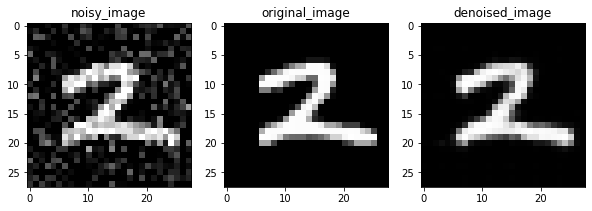

In [24]:
model.eval()

with torch.no_grad():
    
    dataiter = iter(trainloader)
    sample = dataiter.next()
    
    noisy_image,image = sample
    
    index = 0 
    
    pred_image = model(noisy_image[index].unsqueeze(0))
    print(pred_image.squeeze(0).shape)
    show_image(noisy_image[index],image[index],pred_image.squeeze(0))